# Importing Libraries

In [2]:
import os
import numpy as np
import gc
from tqdm import tqdm
import warnings
#warnings.filter('ignore')

# Loading The Images

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import albumentations as alb

aug = alb.Compose([alb.Normalize()])

def load_data(path):
  """Data Loader """

  # Initialize the arrays
  X = []
  y = []

  #change the directory to the path
  os.chdir(path)

  # load images with mask
  mask_path = 'mask'
  os.chdir(mask_path)

  print('loading data with mask')
  for img_dir in tqdm(os.listdir()):
    #X.append(aug(image=img_to_array(load_img(img_dir, color_mode="grayscale", target_size=(224, 224))))['image'])
    X.append(preprocess_input(img_to_array(load_img(img_dir, target_size=(224, 224)))))
    y.append(1)
  os.chdir('../')

  # Load images without mask
  nomask_path = 'nomask'
  os.chdir(nomask_path)

  print('loading data without mask')
  for img_dir in tqdm(os.listdir()):
    try:
      #X.append(aug(image=img_to_array(load_img(img_dir, color_mode="grayscale", target_size=(224, 224))))['image'])
      X.append(preprocess_input(img_to_array(load_img(img_dir, target_size=(224, 224)))))
      y.append(0)
    except:
      pass
  os.chdir('../')

  # back to the orignial directory
  os.chdir('../../../../')

  # change the data to numpy array and returning them
  X = np.array(X)
  y = np.array(y)

  return X, y

In [4]:
main_path = 'drive/MyDrive/Data/'

train_path = f'{main_path}training'
valid_path = f'{main_path}validation'
test_path = f'{main_path}testing'

X_train, y_train = load_data(train_path)
X_valid, y_valid = load_data(valid_path)
X_test, y_test = load_data(test_path)

  0%|          | 0/3002 [00:00<?, ?it/s]

loading data with mask


  0%|          | 9/3002 [00:07<44:19,  1.13it/s]


KeyboardInterrupt: ignored

In [ ]:
# lets shuffle the data



# Building The model

In [75]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Accuracy

def callback(lr=2, es=10):
  return [EarlyStopping(monitor='val_loss', patience=es, verbose=0),
          ReduceLROnPlateau(monitor='val_loss', patience=lr, min_lr=10e-10)]

In [58]:
# lets first check our model

def bulid_model(inp_shape, out_size):
  inp = Input(inp_shape)

  out = BatchNormalization()(inp)
  out = Dropout(.2)(out)

  out = Conv2D(16, (3, 3), padding='same')(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = MaxPool2D((2, 2), 2)(out)

  out = Conv2D(32, (3, 3), strides=2)(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = MaxPool2D((2, 2), 2)(out)

  out = Conv2D(64, (3, 3), strides=2)(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = MaxPool2D((2, 2), 2)(out)

  out = Flatten()(out)

  out = Dense(512)(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(.3)(out)

  out = Dense(64)(out)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(.5)(out)

  out = Dense(out_size)(out)
  out = Activation('sigmoid')(out)

  model = Model(inputs=inp, outputs=out, name="My_model")

  return model


from tensorflow.keras.applications import ResNet50

def transfer_lr(out_size):
  res = ResNet50(include_top=False, pooling='avg', weights='imagenet')
  model = Sequential(
      [res,
      Dense(512),
      BatchNormalization(),
      Activation('relu'),
      Dropout(.3),
      Dense(512),
      BatchNormalization(),
      Activation('elu'),
      Dropout(.6),
      Dense(out_size),
      Activation('sigmoid')]
  )
  
  return model

In [73]:
model = bulid_model((224, 224, 3), 1)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[AUC(), 'accuracy'])

In [ ]:
model = transfer_lr(1)
model.compile(optimizer=SGD(1e-2), loss='binary_crossentropy', metrics=[AUC(), 'accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=1, validation_data=(X_test, y_test), verbose=1, shuffle=True)#, callbacks=callback())

Epoch 1/5
47/47 [==============================] - 29s 621ms/step - loss: 0.8423 - auc_10: 0.6025 - accuracy: 0.5803 - val_loss: 0.7326 - val_auc_10: 0.6905 - val_accuracy: 0.5714
Epoch 2/5
47/47 [==============================] - 28s 602ms/step - loss: 0.8458 - auc_10: 0.6002 - accuracy: 0.5867 - val_loss: 0.6816 - val_auc_10: 0.6882 - val_accuracy: 0.6190
Epoch 3/5
40/47 [========================>.....] - ETA: 4s - loss: 0.8047 - auc_10: 0.6256 - accuracy: 0.5986

KeyboardInterrupt: ignored

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

X_test.shape

(42, 224, 224, 3)

In [13]:
X_test[0].shape 

(224, 224, 3)

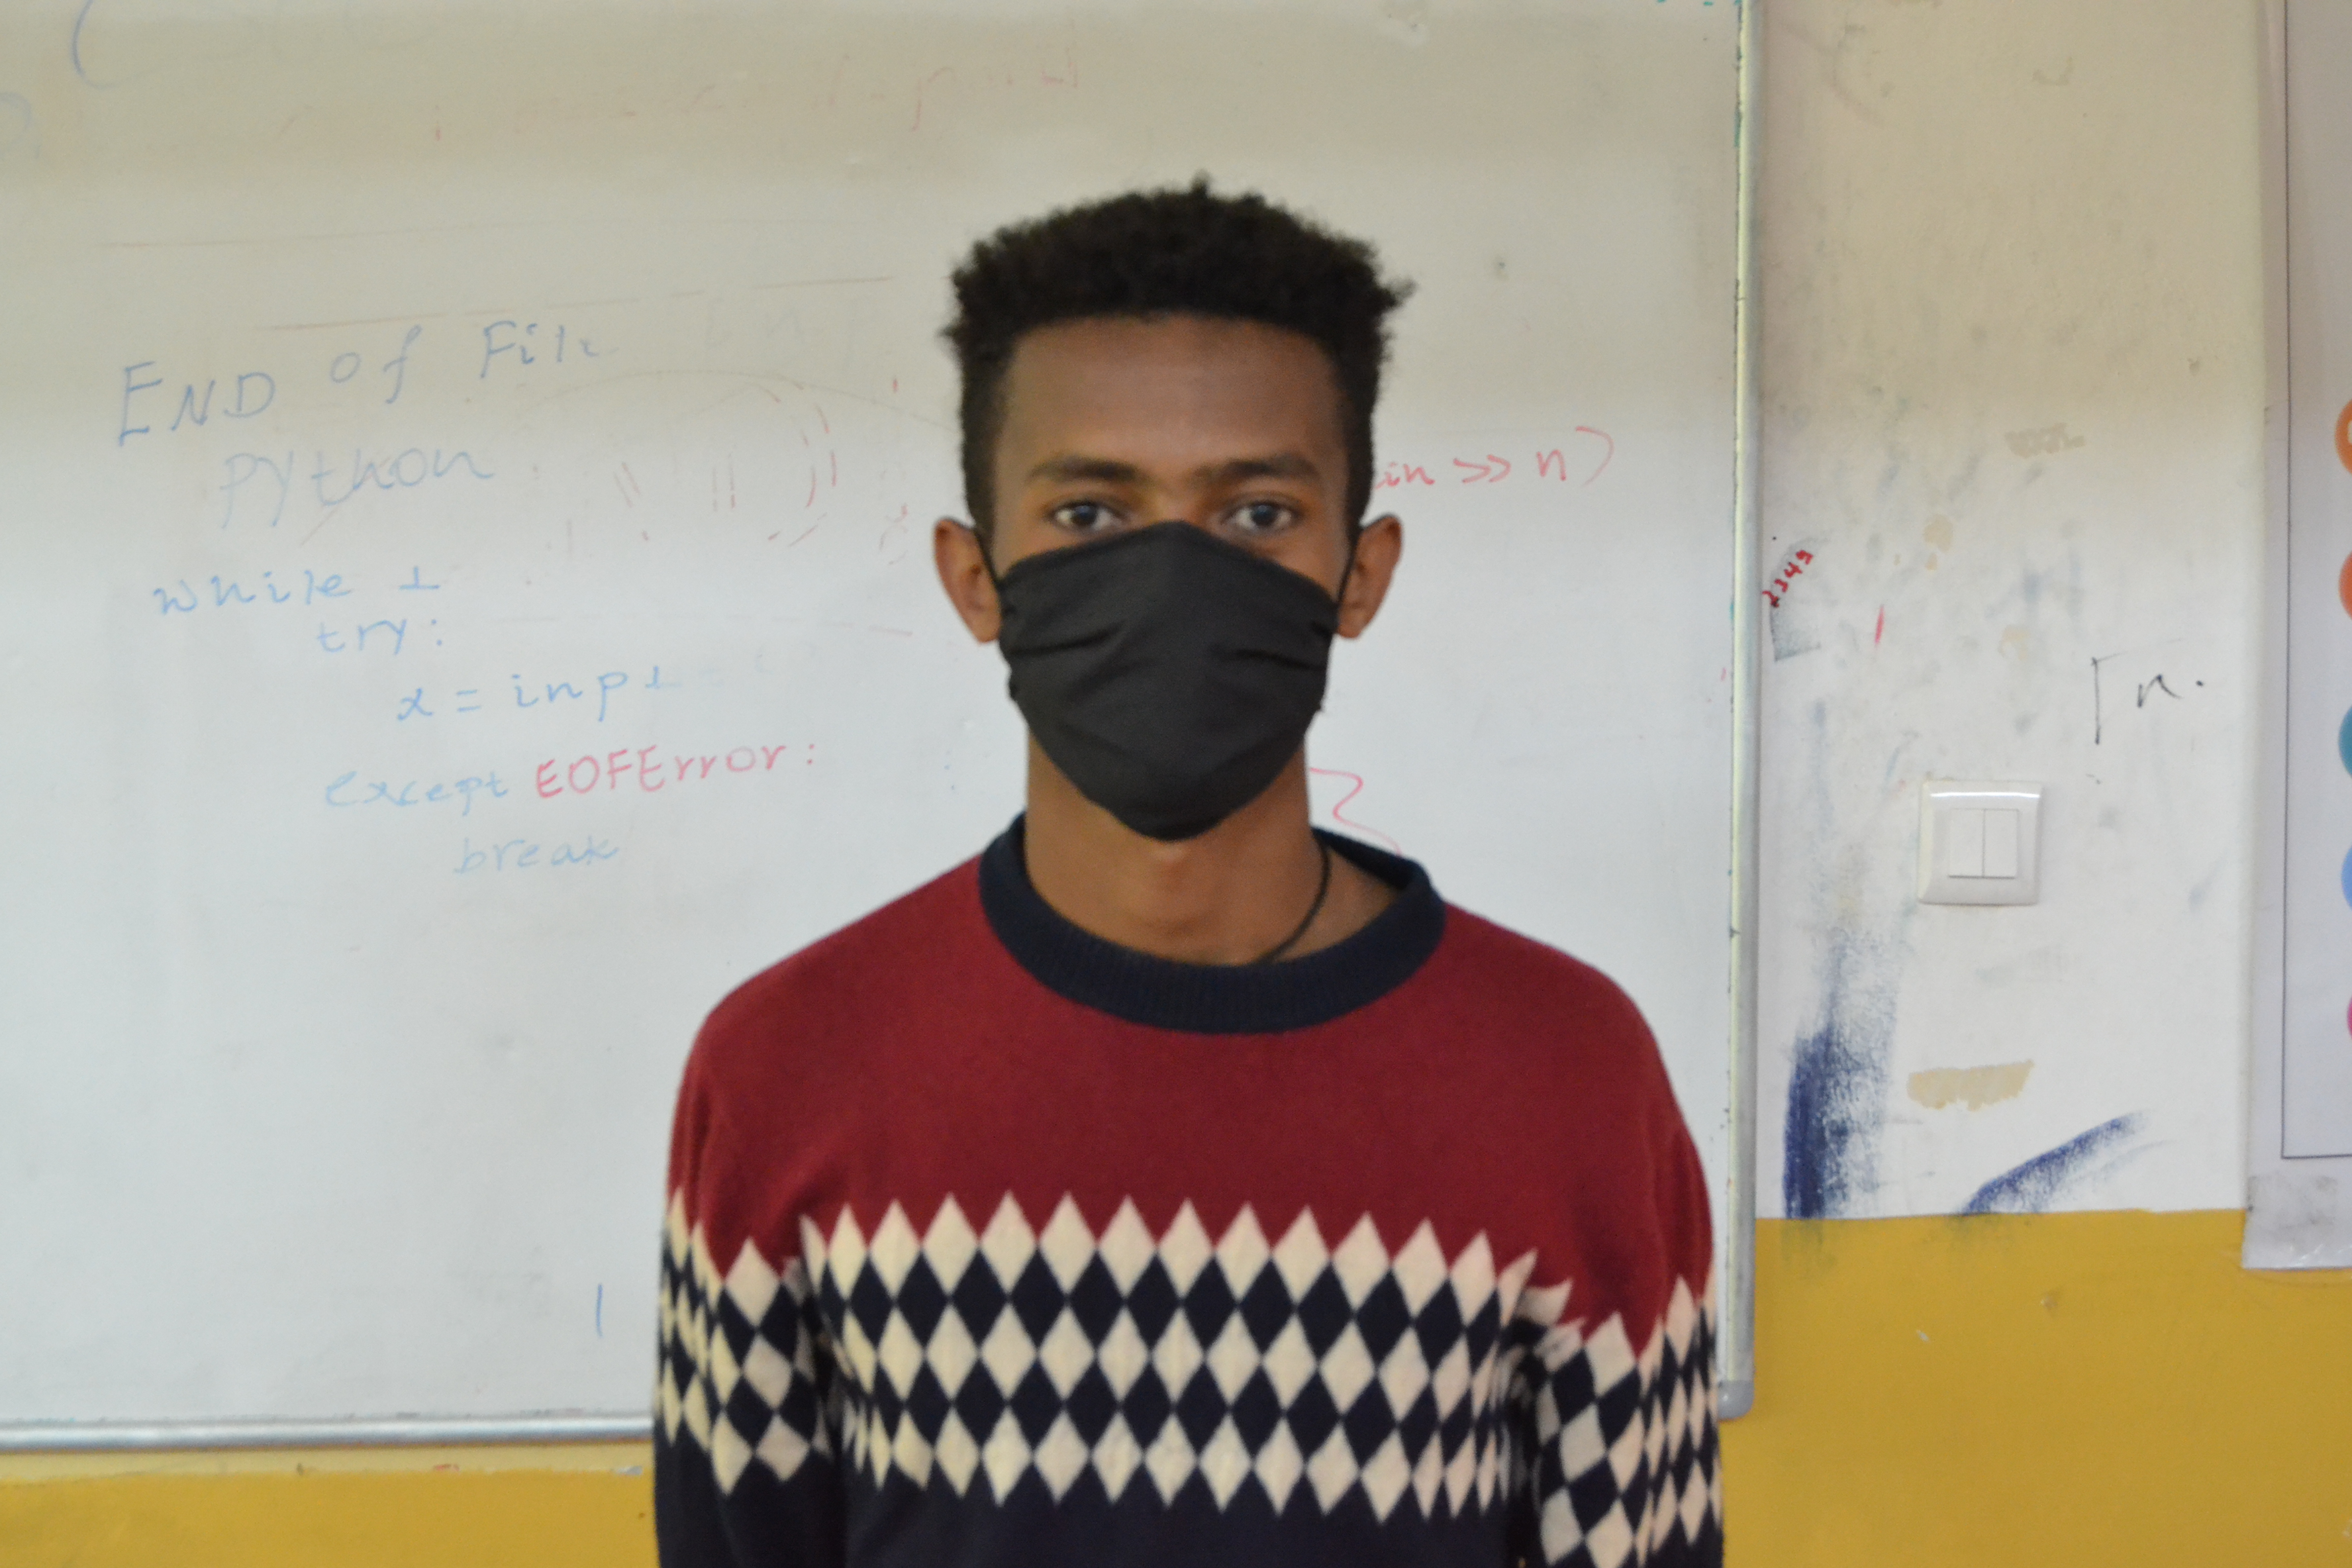

In [41]:
from IPython.display import Image
nn = test_path+'/mask'
Image(nn+'/'+os.listdir(nn)[11])

In [31]:
model.predict(X_test[16].reshape(-1, 224, 224, 3))

array([[0.41336542]], dtype=float32)

In [70]:
os.chdir('drive/MyDrive/Data/models')
model.save('model2.h5')
os.chdir('../../../../')

In [88]:
pred = model.predict(X_valid)

In [63]:
from sklearn.metrics import auc 
pval = model.predict(X_test)
auc(y_test, pval)

0.24157878756523132

In [68]:
pval = model.predict(X_test)

In [69]:
for i in range(len(y_test)):
  print(y_test[i], pval[i])

1 [0.5037511]
1 [0.45208856]
1 [0.40000802]
1 [0.5952016]
1 [0.45508352]
1 [0.42267367]
1 [0.5841079]
1 [0.6727502]
1 [0.6194101]
1 [0.5516249]
1 [0.6057306]
1 [0.59024316]
1 [0.67218256]
1 [0.47175497]
1 [0.7949818]
1 [0.72551996]
1 [0.8403057]
1 [0.47698635]
1 [0.44998047]
1 [0.27557194]
1 [0.5168493]
0 [0.5538237]
0 [0.27384645]
0 [0.40357468]
0 [0.31174856]
0 [0.59590125]
0 [0.40417677]
0 [0.39715636]
0 [0.5755947]
0 [0.5414702]
0 [0.27302894]
0 [0.54575324]
0 [0.33861837]
0 [0.43933013]
0 [0.3266525]
0 [0.3621545]
0 [0.6174758]
0 [0.642804]
0 [0.7678879]
0 [0.5462499]
0 [0.32062814]
0 [0.40141493]


In [5]:
import tensorflow as tf
tf.__version__

'2.3.0'